YouTube Channel Analysis (w/ YouTube API)

In [1]:
# Imports
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data visualization packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# Loading environment variable
import os
from dotenv import load_dotenv
load_dotenv()

# API_Key
api_key = os.environ.get('YOUTUBE_API_KEY')


# List of Channel IDs
CHANNEL_IDS = [
                "UCX6OQ3DkcsbYNE6H8uQQuVA",     # Mr Beast
                "UC-lHJZR3Gqxm24_Vd_AJ5Yw",     # PewDiePie
                "UCINb0wqPz-A0dV9nARjJlOQ",     # The Dodo
                "UCshoKvlZGZ20rVgazZp5vnQ",     # CaptainSparklez
                "UCY1kMZp36IQSyNx_9h4mpCg",     # Mark Rober
                "UC6nSFpj9HTCZ5t-N3Rm3-HA",     # Vsauce
                "UCiDJtJKMICpb9B1qf7qjEOA",     # Adam Savage's Tested
              ]

In [2]:
api_service_name = "youtube"
api_version = "v3"
youtube = build(api_service_name, api_version, developerKey=api_key)


def get_channel_stats(youtube, CHANNEL_IDS):
  all_data = []

  request = youtube.channels().list(
    part ='snippet,contentDetails,statistics',
    id=','.join(CHANNEL_IDS)
  )
  response = request.execute()

  JSON(response)

  # Looping through items / refer to properties in YouTube API doc
  # https://developers.google.com/youtube/v3/docs/channels
  for item in response['items']:
    data = {
      'channelName': item['snippet']['title'],
      'subscribers': item['statistics']['subscriberCount'],
      'views': item['statistics']['viewCount'],
      'totalVideos': item['statistics']['videoCount'],            
      'playlistId': item['contentDetails']['relatedPlaylists']['uploads'],
    }

    all_data.append(data)



  return(pd.DataFrame(all_data))

#-----------------------------------------------------------#

# # Get credentials and create an API client
# youtube = build(api_service_name, api_version, developerKey=api_key)

# request = youtube.channels().list(
#   part ='snippet,contentDetails,statistics',
#   id=','.join(CHANNEL_IDS)
# )
# response = request.execute()

# #print(response)
# JSON(response)

In [3]:
channel_stats = get_channel_stats(youtube, CHANNEL_IDS)
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Vsauce,19600000,3021806679,467,UU6nSFpj9HTCZ5t-N3Rm3-HA
1,CaptainSparklez,11400000,4040153027,5739,UUshoKvlZGZ20rVgazZp5vnQ
2,Mark Rober,24700000,3686972208,121,UUY1kMZp36IQSyNx_9h4mpCg
3,MrBeast,176000000,30124700398,744,UUX6OQ3DkcsbYNE6H8uQQuVA
4,The Dodo,14400000,10162528894,8010,UUINb0wqPz-A0dV9nARjJlOQ
5,Adam Savage’s Tested,6320000,1396149332,6378,UUiDJtJKMICpb9B1qf7qjEOA
6,PewDiePie,111000000,29090161310,4717,UU-lHJZR3Gqxm24_Vd_AJ5Yw


In [4]:
playlist_id = "PLoSWVnSA9vG9qV0CVCpg5WwEy3LiP7udY"      # mrbeast "new uploads" playlist

def get_video_ids(youtube, playlist_id):
  video_ids = []
  
  request = youtube.playlistItems().list(
  part='snippet,contentDetails',
  playlistId=playlist_id,
  maxResults=50       # default is 5 video ids
  )
  response = request.execute()

  for item in response['items']:
    video_ids.append(item['contentDetails']['videoId'])

  
  next_page_token = response.get('nextPageToken')
  while next_page_token is not None:

    request = youtube.playlistItems().list(
      part='snippet,contentDetails',
      playlistId=playlist_id,
      maxResults=50,       # default is 5 video ids
      pageToken = next_page_token
    )
    response = request.execute()

    for item in response['items']:
      video_ids.append(item['contentDetails']['videoId'])

    next_page_token = response.get('nextPageToken')

  return video_ids


# # Display details about playlist item
# request = youtube.playlistItems().list(
#   part="snippet,contentDetails",
#   playlistId="PLoSWVnSA9vG9qV0CVCpg5WwEy3LiP7udY"
# )
# response = request.execute()

# JSON(response)

In [5]:
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)

222

In [6]:

# Fetches data from get_video_ids
def get_video_details(youtube, video_ids):
  all_video_info = []

  for i in range(0, len(video_ids), 50):
    request = youtube.videos().list(
      part='snippet,contentDetails,statistics',
      id=','.join(video_ids[i:i+50])
    )
    response = request.execute()

    for video in response['items']:
      ideal_stats = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                    'contentDetails': ['duration', 'definition', 'caption'],
                    'statistics': ['viewCount', 'likeCount', 'favoriteCount', 'commentCount']
                    }
      
      video_info = {}
      video_info['video_id'] = video['id']

      for k in ideal_stats.keys():
        for v in ideal_stats[k]:
          try:
            video_info[v] = video[k][v]
          except:
            video_info[v] = None        # not all videos will have info added

      all_video_info.append(video_info)

  #JSON(response)
  return pd.DataFrame(all_video_info)

In [7]:
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,duration,definition,caption,viewCount,likeCount,favoriteCount,commentCount
0,jObOjhUkf50,MrBeast,"$1 vs $250,000 Vacation!","I did not expect the $250,000 vacation to be t...",None,2023-08-12T15:59:59Z,PT16M7S,hd,true,72601150,3666401,0,86203
1,yhB3BgJyGl8,MrBeast,7 Days Stranded At Sea,🚀 Launch a store on Shopify right now 👉 https:...,None,2023-08-05T16:00:01Z,PT18M5S,hd,true,116486012,5136639,0,108332
2,fuhE6PYnRMc,MrBeast,Train Vs Giant Pit,Go buy my merch at https://mrbeast.store and i...,None,2023-07-08T16:00:00Z,PT10M36S,hd,true,134847816,5382109,0,135507
3,48h57PspBec,MrBeast,"$1 vs $1,000,000,000 Yacht!",Buy Feastables anywhere to get a secret MrBeas...,None,2023-06-10T16:00:00Z,PT14M47S,hd,true,200861131,5623102,0,143992
4,FM7Z-Xq8Drc,MrBeast,"Ages 1 - 100 Fight For $500,000",Claim a piece of MrBeast history — buy a prop ...,None,2023-05-27T21:14:59Z,PT25M36S,hd,true,198833822,5192745,0,111755
...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2Pvt8awds44,MrBeast,Walking Up To Random People With 100 StormTroo...,THE EMPIRE CAN NOT BE STOPPED\n\nSUBSCRIBE OR ...,"[experiment, prank, star wars, hacks, life hac...",2018-04-11T22:09:01Z,PT10M4S,hd,false,19216408,499394,0,39672
218,n9BbAfbsyj0,MrBeast,"I Donated $10,000 If They Said This Word (Twit...","SHE SAID SO I GAVE HER $10,000\n\nTwitter - @m...","[donating to twitch streamers, twitch streamer...",2018-04-04T22:19:00Z,PT13M5S,hd,false,19977384,558216,0,22510
219,WZ2rYlVxt4g,MrBeast,"Giving My 4,000,000th Subscriber 4,000,000 Coo...",I GAVE HIM A LOT OF COOKIES\nSUBSCRIBE OR I DE...,[cookies],2018-04-02T22:09:01Z,PT10M41S,hd,false,13143981,345126,0,25661
220,CWK6an4mYL0,MrBeast,"I Tipped Waitresses $20,000",WE GAVE AWAY SO MUCH MONEY\n\nDownload Fortnit...,[tipping waitresses 10000],2018-03-30T21:09:03Z,PT12M24S,hd,false,14646296,353582,0,20159


## Data Pre-processing

In [8]:
# Null Values
video_df.isnull().any()

video_id         False
channelTitle     False
title            False
description      False
tags              True
publishedAt      False
duration         False
definition       False
caption          False
viewCount        False
likeCount        False
favoriteCount    False
commentCount     False
dtype: bool

In [9]:
# Data Types
video_df.dtypes

video_id         object
channelTitle     object
title            object
description      object
tags             object
publishedAt      object
duration         object
definition       object
caption          object
viewCount        object
likeCount        object
favoriteCount    object
commentCount     object
dtype: object

In [10]:
# Converting (parameter part: statistics) to numerical data type
numeric_cols = ['viewCount', 'likeCount', 'favoriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [11]:
# Not working / Needs fixing

# import argparse
# parser = argparse.ArgumentParser()
# args = parser.parse_args()

# # Converting "publishedAt" to "publishDayName" -- Identify publish day in the week
# video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x : parser.parse(x))
# video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [12]:
import isodate
video_df['durationSecs'] = video_df['duration'].apply(lambda x : isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,0 days 00:16:07,PT16M7S
1,0 days 00:18:05,PT18M5S
2,0 days 00:10:36,PT10M36S
3,0 days 00:14:47,PT14M47S
4,0 days 00:25:36,PT25M36S
...,...,...
217,0 days 00:10:04,PT10M4S
218,0 days 00:13:05,PT13M5S
219,0 days 00:10:41,PT10M41S
220,0 days 00:12:24,PT12M24S


In [13]:
# Create "TagCount" column
video_df['tagCount'] = video_df['tags'].apply(lambda x : 0 if x is None else len(x))


In [14]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,duration,definition,caption,viewCount,likeCount,favoriteCount,commentCount,durationSecs,tagCount
0,jObOjhUkf50,MrBeast,"$1 vs $250,000 Vacation!","I did not expect the $250,000 vacation to be t...",None,2023-08-12T15:59:59Z,PT16M7S,hd,true,72601150,3666401,0,86203,0 days 00:16:07,0
1,yhB3BgJyGl8,MrBeast,7 Days Stranded At Sea,🚀 Launch a store on Shopify right now 👉 https:...,None,2023-08-05T16:00:01Z,PT18M5S,hd,true,116486012,5136639,0,108332,0 days 00:18:05,0
2,fuhE6PYnRMc,MrBeast,Train Vs Giant Pit,Go buy my merch at https://mrbeast.store and i...,None,2023-07-08T16:00:00Z,PT10M36S,hd,true,134847816,5382109,0,135507,0 days 00:10:36,0
3,48h57PspBec,MrBeast,"$1 vs $1,000,000,000 Yacht!",Buy Feastables anywhere to get a secret MrBeas...,None,2023-06-10T16:00:00Z,PT14M47S,hd,true,200861131,5623102,0,143992,0 days 00:14:47,0
4,FM7Z-Xq8Drc,MrBeast,"Ages 1 - 100 Fight For $500,000",Claim a piece of MrBeast history — buy a prop ...,None,2023-05-27T21:14:59Z,PT25M36S,hd,true,198833822,5192745,0,111755,0 days 00:25:36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217,2Pvt8awds44,MrBeast,Walking Up To Random People With 100 StormTroo...,THE EMPIRE CAN NOT BE STOPPED\n\nSUBSCRIBE OR ...,"[experiment, prank, star wars, hacks, life hac...",2018-04-11T22:09:01Z,PT10M4S,hd,false,19216408,499394,0,39672,0 days 00:10:04,10
218,n9BbAfbsyj0,MrBeast,"I Donated $10,000 If They Said This Word (Twit...","SHE SAID SO I GAVE HER $10,000\n\nTwitter - @m...","[donating to twitch streamers, twitch streamer...",2018-04-04T22:19:00Z,PT13M5S,hd,false,19977384,558216,0,22510,0 days 00:13:05,3
219,WZ2rYlVxt4g,MrBeast,"Giving My 4,000,000th Subscriber 4,000,000 Coo...",I GAVE HIM A LOT OF COOKIES\nSUBSCRIBE OR I DE...,[cookies],2018-04-02T22:09:01Z,PT10M41S,hd,false,13143981,345126,0,25661,0 days 00:10:41,1
220,CWK6an4mYL0,MrBeast,"I Tipped Waitresses $20,000",WE GAVE AWAY SO MUCH MONEY\n\nDownload Fortnit...,[tipping waitresses 10000],2018-03-30T21:09:03Z,PT12M24S,hd,false,14646296,353582,0,20159,0 days 00:12:24,1


# Exploratory Data $~~~~~~~$<img src="https://i.gifer.com/40Oj.gif" alt="John-Travolta" width="40" height="40">

<h4>Most viewed videos</h4>

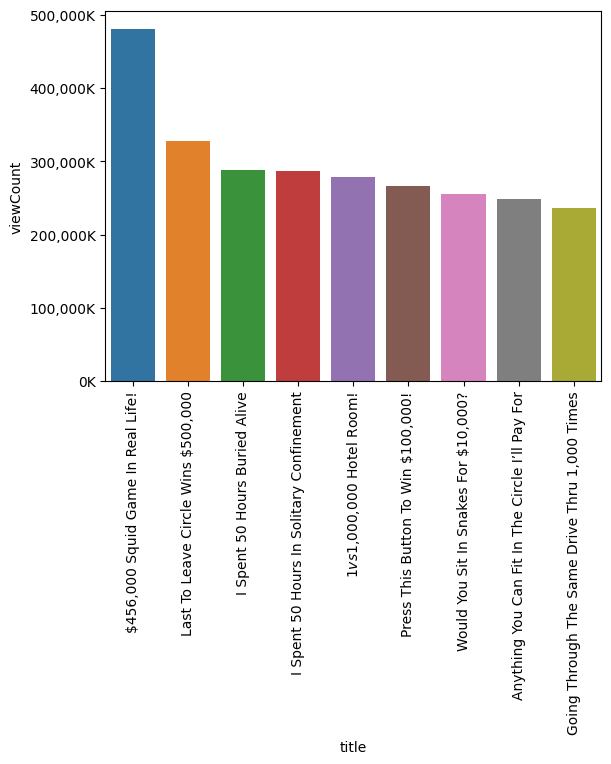

In [15]:
ax = sns.barplot(x='title', y='viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))
plt.show()

<h4>Least viewed videos</h4>

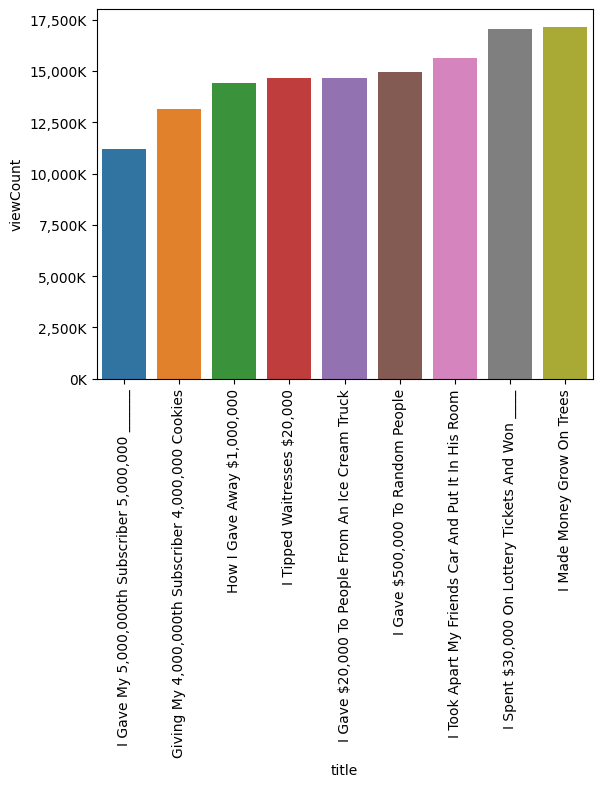

In [16]:
ax = sns.barplot(x='title', y='viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))
plt.show()